<a href="https://colab.research.google.com/github/Salimovsky/StockML/blob/master/Microsoft_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

In [0]:
## Install TA from its source code library:

# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib
# import talib


## OR install TA lib binary

# !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
# !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
# !dpkg -i libta.deb ta.deb
# !pip install Ta-Lib
# import talib


In [0]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import talib

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">[weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [0]:
# uncomment this line to remove cached file if you need to reload an updated version of raw data file
#!rm ~/.keras/datasets/MSFT.csv
file_path = tf.keras.utils.get_file(
    origin='https://docs.google.com/uc?export=download&id=14Y3yvzY8CEIIg-C4vX4HsSwJxGU3sx7B',
    fname='MSFT.csv',
    extract=False)
unzipped_csv_path, _ = os.path.splitext(file_path)

In [0]:
df = pd.read_csv(file_path, sep='|')

Let's take a glance at the data.

In [5]:
df.head()

,MSFT timestampMs,MSFT monthOfYear,MSFT dayOfMonth,MSFT dayOfWeek,MSFT hourOfDay,MSFT minuteOfHour,MSFT volume,MSFT weightedPrice,MSFT open,MSFT high,...,MSFT Days Avg 20 High,MSFT Days Avg 50 Low,MSFT Days Avg 50 Weighted,MSFT Days Avg 50 High,MSFT Days Avg 100 Low,MSFT Days Avg 100 Weighted,MSFT Days Avg 100 High,MSFT Days Avg 200 Low,MSFT Days Avg 200 Weighted,MSFT Days Avg 200 High
0,1546419600000,1,2,4,3,0,387.0,99.4000,99.40,99.40,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
1,1546419840000,1,2,4,3,4,371.0,98.9013,98.88,98.88,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
2,1546420320000,1,2,4,3,12,100.0,99.2000,99.20,99.20,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
3,1546420500000,1,2,4,3,15,380.0,99.2000,99.20,99.20,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615
4,1546420980000,1,2,4,3,23,188.0,99.2330,99.20,99.20,...,106.233088,103.639316,105.459754,107.401061,105.840074,107.397918,109.023975,101.771254,103.103047,104.459615


In [0]:
from talib import MA_Type

## Technical Analysis Indicators
ta_weighted_price = 'MSFT weightedPrice'
ta_volume = 'MSFT volume'
ta_time_stamp = 'MSFT timestampMs'
ta_obv = 'MSFT OBV'

wighted_prices = df[ta_weighted_price].values
open = df['MSFT open'].values
high = df['MSFT high'].values
low = df['MSFT low'].values
close = df['MSFT close'].values
volume = df[ta_volume].values

price_SMA_50 = talib.SMA(wighted_prices, timeperiod=50)
price_SMA_100 = talib.SMA(wighted_prices, timeperiod=100)
price_SMA_200 = talib.SMA(wighted_prices, timeperiod=200)
price_DEMA_5 = talib.DEMA(wighted_prices, timeperiod=5)
price_DEMA_10 = talib.DEMA(wighted_prices, timeperiod=10)
price_DEMA_20 = talib.DEMA(wighted_prices, timeperiod=20)
bbands_20 = talib.BBANDS(wighted_prices, timeperiod=20, matype=MA_Type.T3)
bbands_10 = talib.BBANDS(wighted_prices, timeperiod=10, matype=MA_Type.T3)
rsi_14 = talib.RSI(wighted_prices, timeperiod=14)
stoch_14 = talib.STOCH(high, low, wighted_prices, fastk_period=14)
obv = talib.OBV(wighted_prices, volume)
macd = talib.MACD(wighted_prices, fastperiod=12, slowperiod=26, signalperiod=9)


df['MSFT SMA 50'] = price_SMA_50
df['MSFT SMA 100'] = price_SMA_100
df['MSFT SMA 200'] = price_SMA_200
df['MSFT DEMA 5'] = price_DEMA_5
df['MSFT DEMA 10'] = price_DEMA_10
df['MSFT DEMA 20'] = price_DEMA_20
df['MSFT BBANDS 20 UPPER'], df['MSFT BBANDS 20 MIDDLE'], df['MSFT BBANDS 20 LOWER'] = bbands_20
df['MSFT BBANDS 10 UPPER'], df['MSFT BBANDS 10 MIDDLE'], df['MSFT BBANDS 10 LOWER'] = bbands_10
df['MSFT RSI 14'] = rsi_14
df['MSFT STOCH 14 lowk'], df['MSFT STOCH 14 lowd'] = stoch_14
df[ta_obv] = obv
df['MSFT macd'], df['MSFT macdsignal'], df['MSFT macdhist']= macd

In [7]:
df.tail(10)

,MSFT timestampMs,MSFT monthOfYear,MSFT dayOfMonth,MSFT dayOfWeek,MSFT hourOfDay,MSFT minuteOfHour,MSFT volume,MSFT weightedPrice,MSFT open,MSFT high,...,MSFT BBANDS 10 UPPER,MSFT BBANDS 10 MIDDLE,MSFT BBANDS 10 LOWER,MSFT RSI 14,MSFT STOCH 14 lowk,MSFT STOCH 14 lowd,MSFT OBV,MSFT macd,MSFT macdsignal,MSFT macdhist
136995,1577838600000,12,31,3,18,30,462.0,157.7436,157.74,157.74,...,157.942869,157.850329,157.757788,39.418568,14.379545,40.805808,132270692.0,0.001453,0.013947,-0.012494
136996,1577838660000,12,31,3,18,31,9251.0,157.7011,157.72,157.72,...,157.970989,157.843568,157.716147,35.591875,4.780861,22.024428,132261441.0,-0.008927,0.009372,-0.018300
136997,1577838780000,12,31,3,18,33,600.0,157.7333,157.80,157.80,...,157.971127,157.833219,157.695310,40.319135,6.835088,8.665165,132262041.0,-0.014390,0.004620,-0.019010
136998,1577839140000,12,31,3,18,39,322.0,157.7700,157.77,157.77,...,157.956032,157.821430,157.686828,45.251299,18.315789,9.977246,132262363.0,-0.015578,0.000580,-0.016158
136999,1577839320000,12,31,3,18,42,140.0,157.8000,157.80,157.80,...,157.933668,157.810298,157.686927,48.964231,35.666667,20.272515,132262503.0,-0.013938,-0.002323,-0.011615
137000,1577839920000,12,31,3,18,52,177.0,157.7700,157.77,157.77,...,157.908729,157.800151,157.691572,45.631555,42.105263,32.029240,132262326.0,-0.014888,-0.004836,-0.010052
137001,1577839980000,12,31,3,18,53,800.0,157.8000,157.80,157.80,...,157.893345,157.791887,157.690430,49.344555,47.368421,41.713450,132263126.0,-0.013069,-0.006483,-0.006586
137002,1577840220000,12,31,3,18,57,166.0,157.7810,157.78,157.78,...,157.857961,157.785330,157.712699,47.148405,44.035088,44.502924,132262960.0,-0.013011,-0.007788,-0.005222
137003,1577840280000,12,31,3,18,58,1183.0,157.8307,157.78,157.84,...,157.853141,157.781437,157.709734,53.036451,54.684211,48.695906,132264143.0,-0.008852,-0.008001,-0.000851
137004,1577840340000,12,31,3,18,59,200.0,157.8500,157.85,157.85,...,157.865980,157.780747,157.695515,55.127108,63.456140,54.058480,132264343.0,-0.003954,-0.007192,0.003238


In [8]:
nan_list = [price_SMA_50, price_SMA_100, price_SMA_200, *bbands_20, rsi_14, *macd]
for i in nan_list:
  print(np.count_nonzero(np.isnan(i)))

49
99
199
114
114
114
14
33
33
33


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations. 

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [10]:
TRAIN_SPLIT = np.long(df[ta_weighted_price].values.size * 0.85)
print("Training set size = %s" % (TRAIN_SPLIT))

Training set size = 116454


Setting seed to ensure reproducibility.

In [0]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [12]:
uni_data = df[ta_weighted_price]
uni_data.index = df[ta_time_stamp]
uni_data.head()

MSFT timestampMs
1546419600000    99.4000
1546419840000    98.9013
1546420320000    99.2000
1546420500000    99.2000
1546420980000    99.2330
Name: MSFT weightedPrice, dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5cac6ae50>],
      dtype=object)

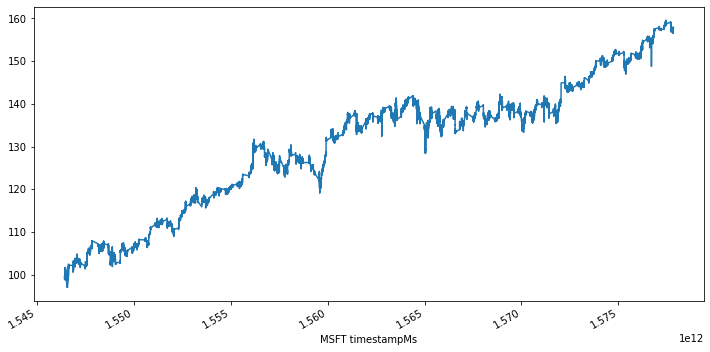

In [13]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [0]:
univariate_past_history = 60
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

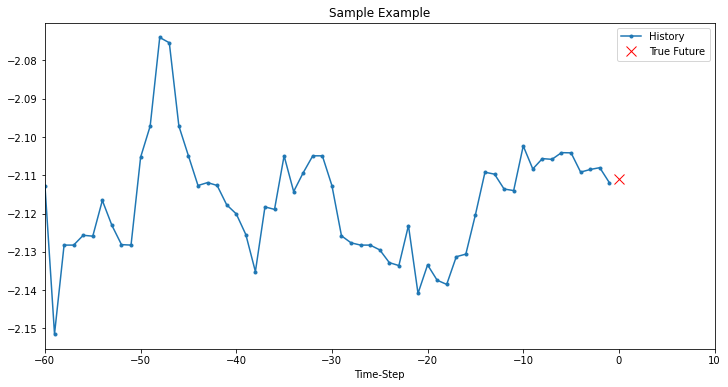

In [20]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

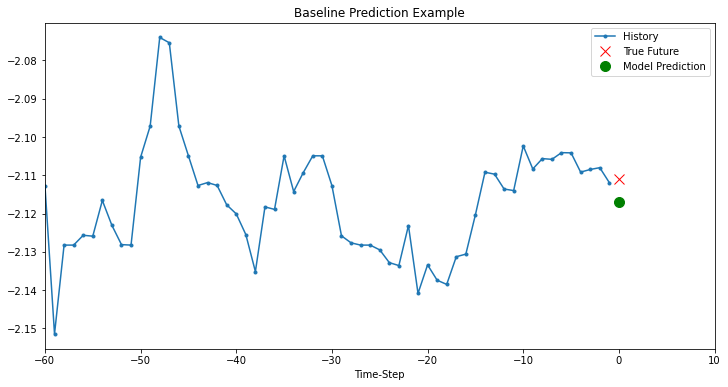

In [22]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/time_series.png?raw=1)

In [24]:
print(x_train_uni.shape)

(116394, 60, 1)


You will see the LSTM requires the input shape of the data it is being given.

In [33]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_uni.shape[-2:], return_sequences=True, dropout=0.1),
    tf.keras.layers.LSTM(16),
    # tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.summary()
simple_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 32)            4352      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


Let's make a sample prediction, to check the output of the model. 

In [26]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [0]:
EVALUATION_INTERVAL = 1000
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=100)

Epoch 1/20
1000/1000 [==============================] - 8s 8ms/step - loss: 9.1684e-05 - mae: 0.0059 - val_loss: 0.0791 - val_mae: 0.2740
Epoch 2/20
1000/1000 [==============================] - 8s 8ms/step - loss: 9.5554e-05 - mae: 0.0060 - val_loss: 0.0245 - val_mae: 0.1503
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 9.3140e-05 - mae: 0.0059 - val_loss: 0.0420 - val_mae: 0.1972
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 9.2470e-05 - mae: 0.0059 - val_loss: 0.0428 - val_mae: 0.1992
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 9.0412e-05 - mae: 0.0057 - val_loss: 0.0409 - val_mae: 0.1946
Epoch 6/20
1000/1000 [==============================] - 8s 8ms/step - loss: 9.7284e-05 - mae: 0.0060 - val_loss: 0.0766 - val_mae: 0.2697
Epoch 7/20
1000/1000 [==============================] - 8s 8ms/step - loss: 9.0787e-05 - mae: 0.0058 - val_loss: 0.0433 - val_mae: 0.1996
Epoch 8/20
1000/1000 [============

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

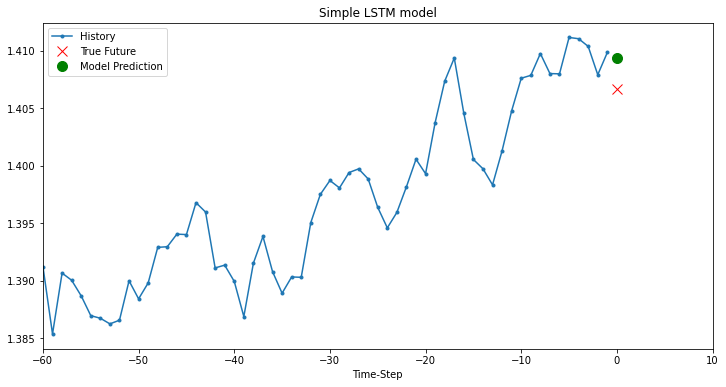

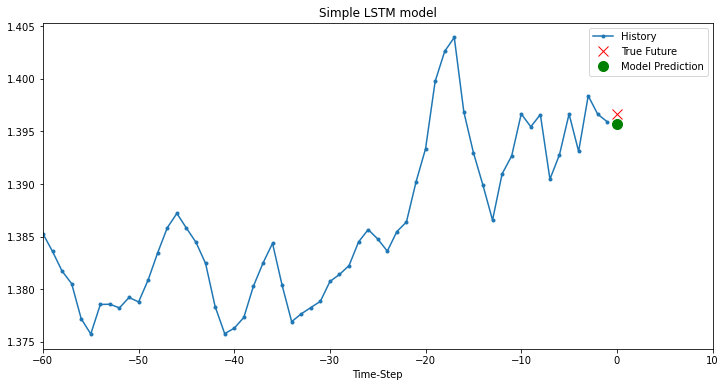

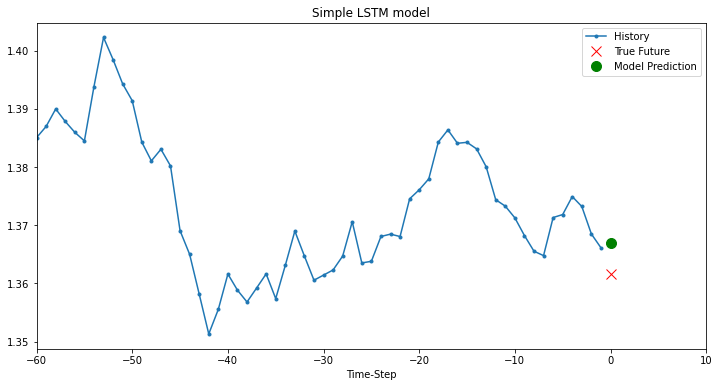

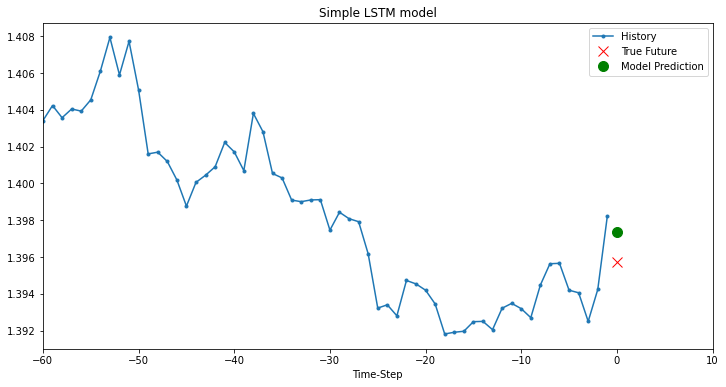

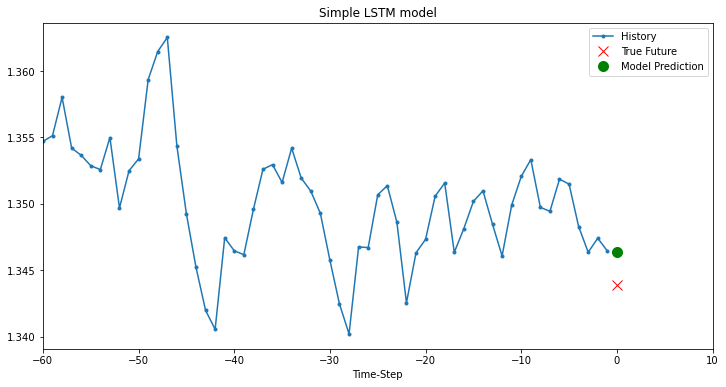

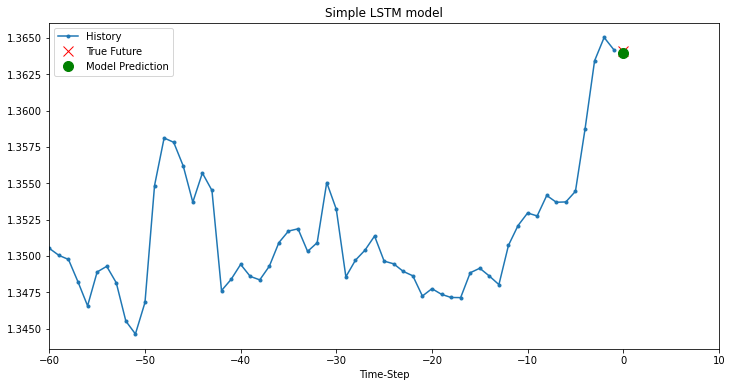

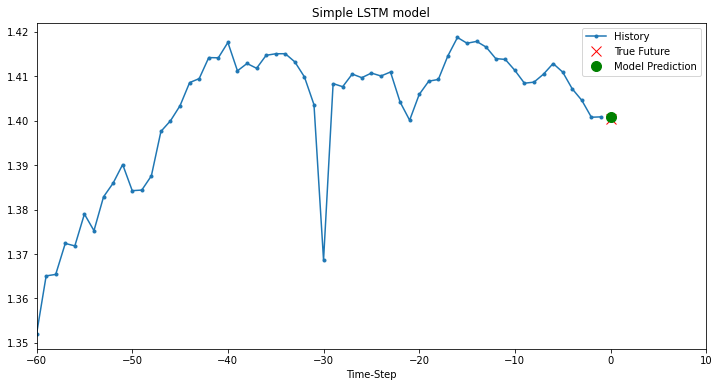

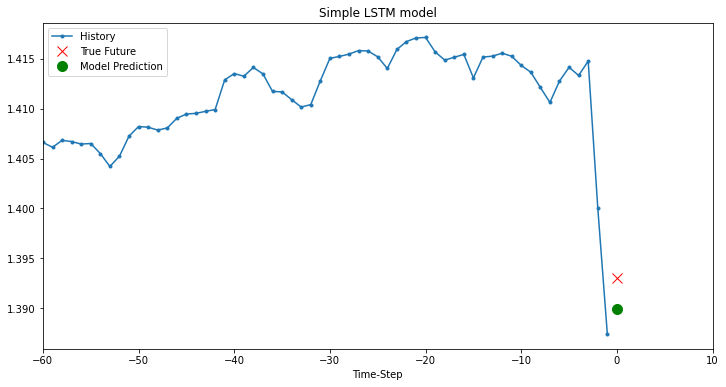

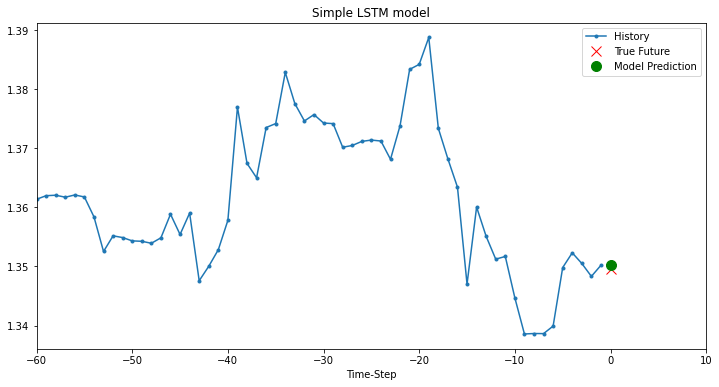

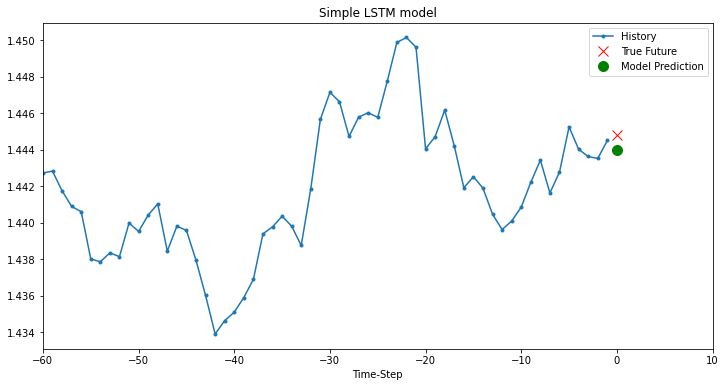

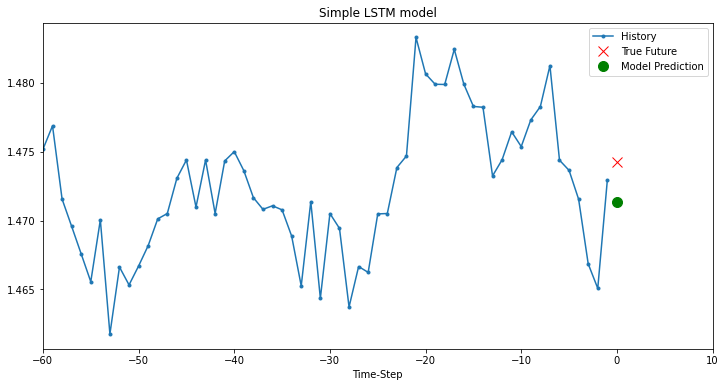

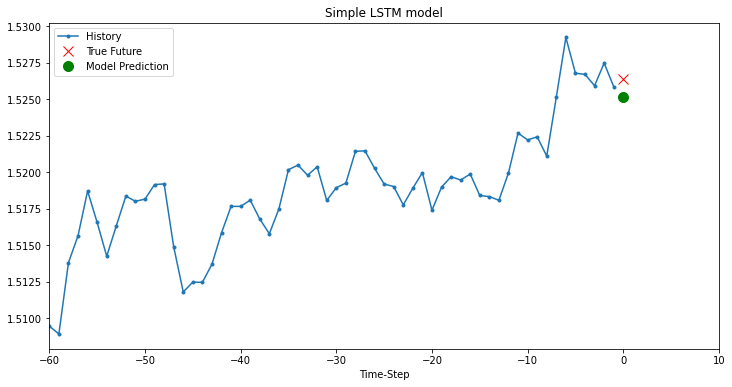

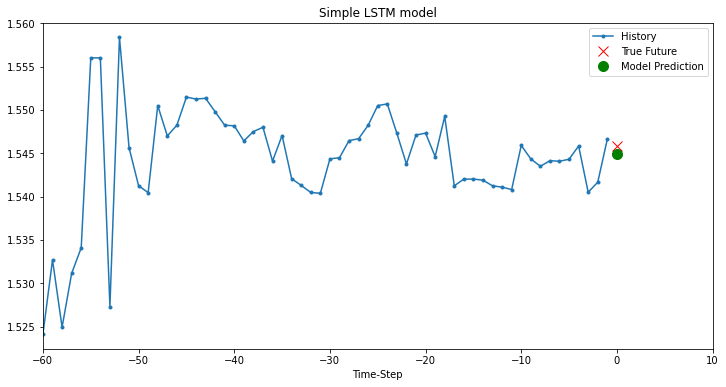

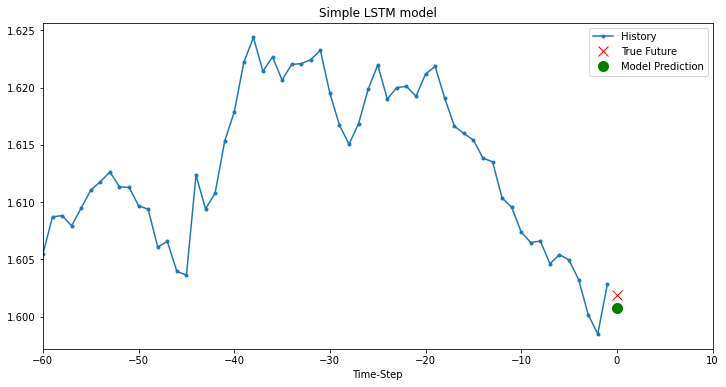

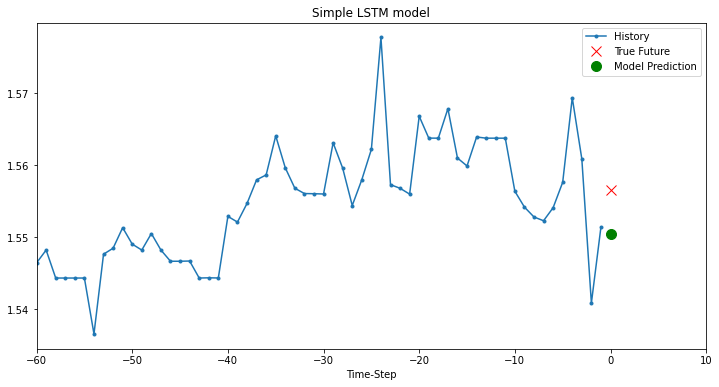

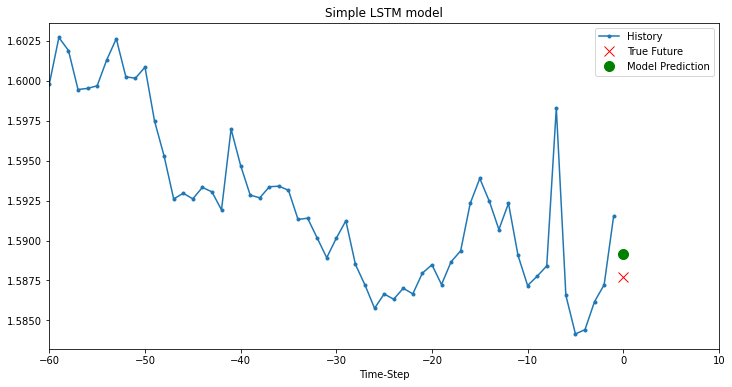

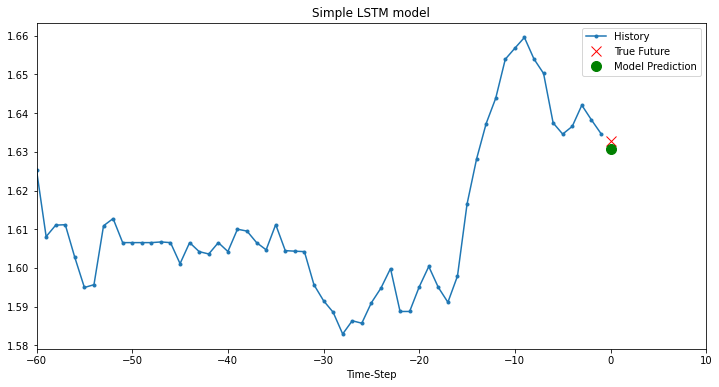

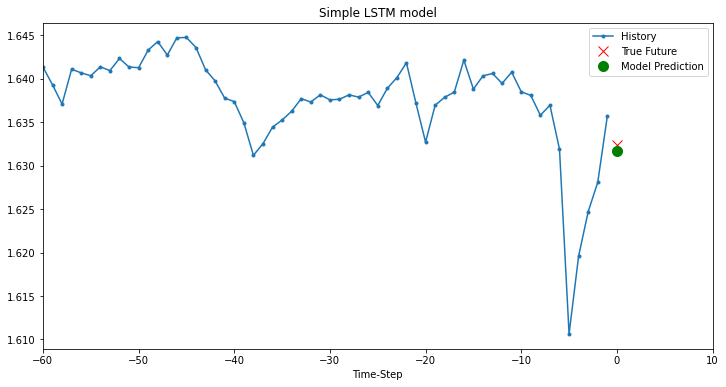

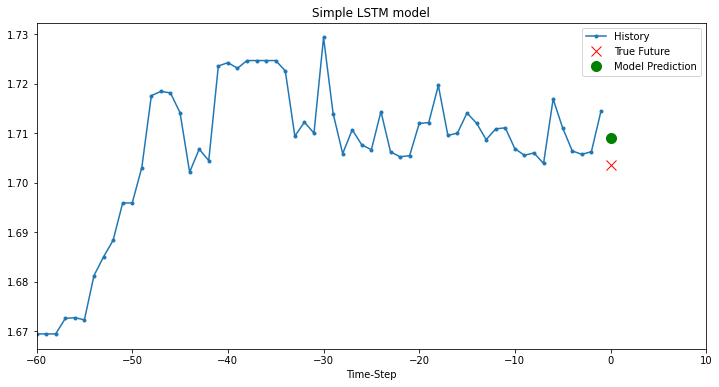

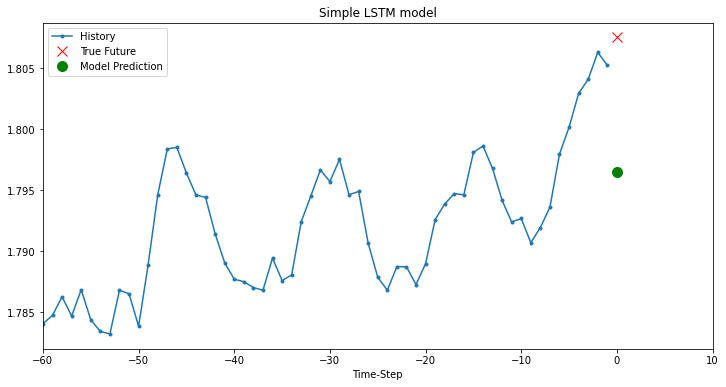

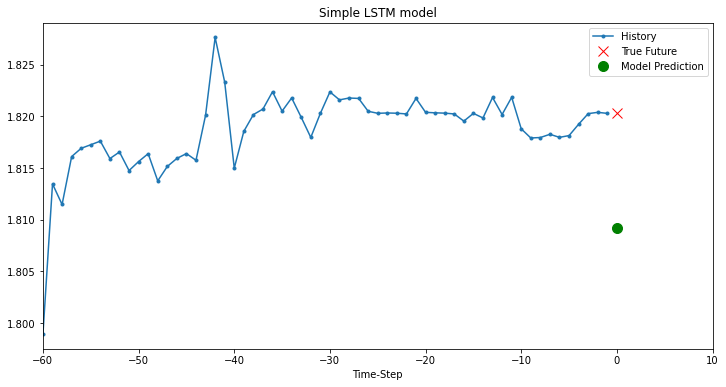

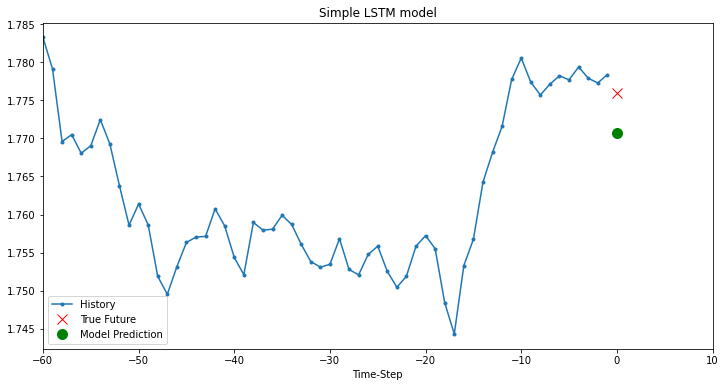

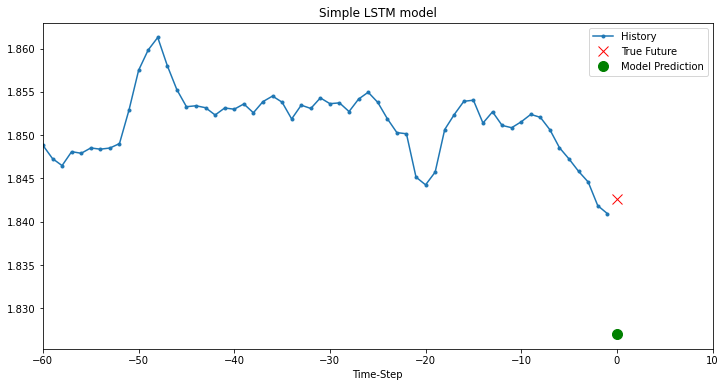

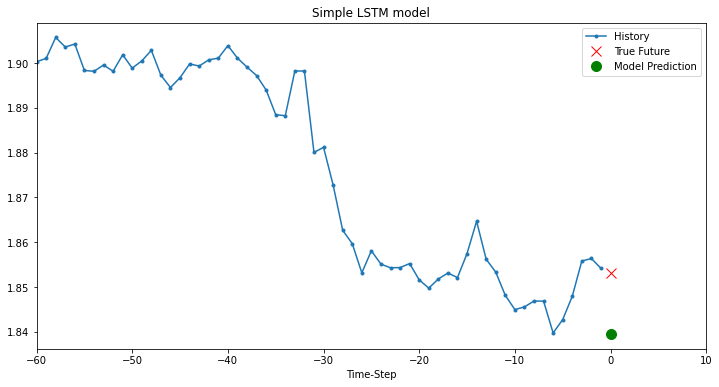

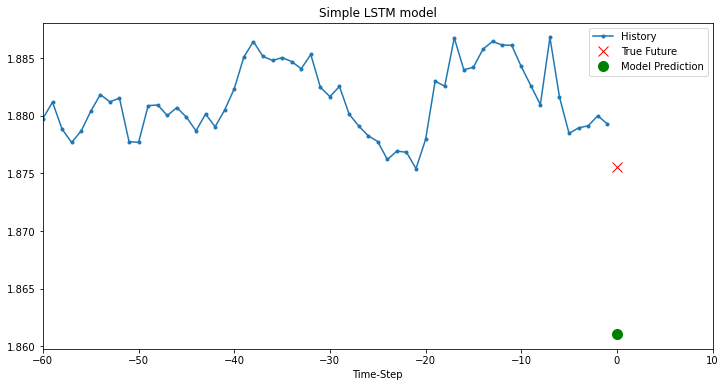

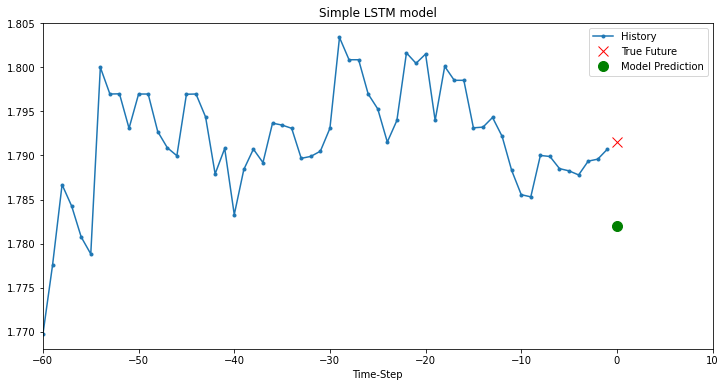

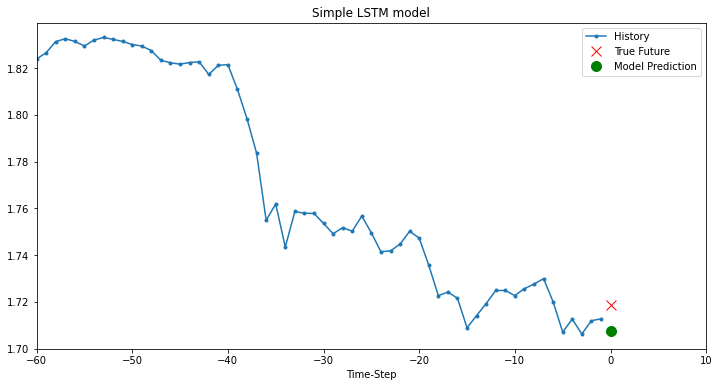

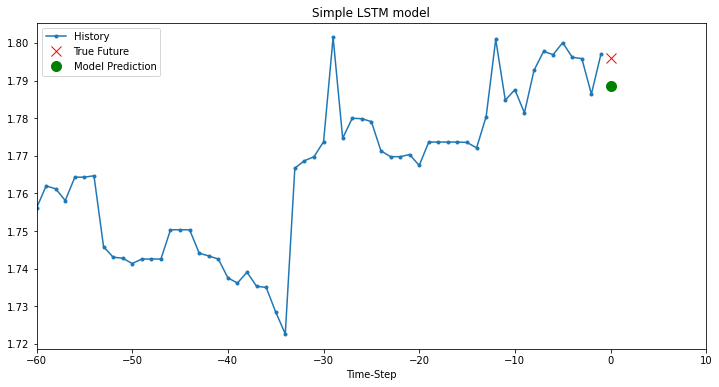

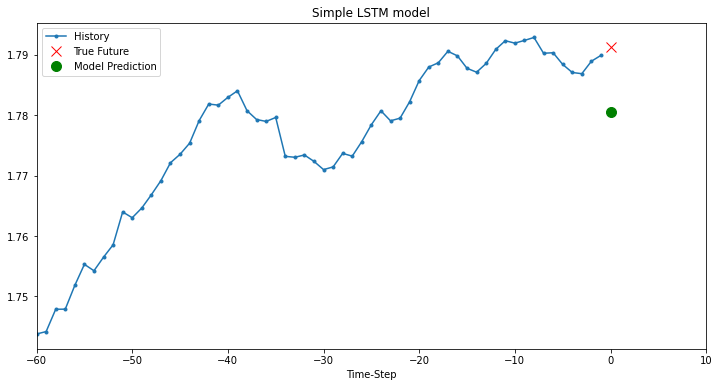

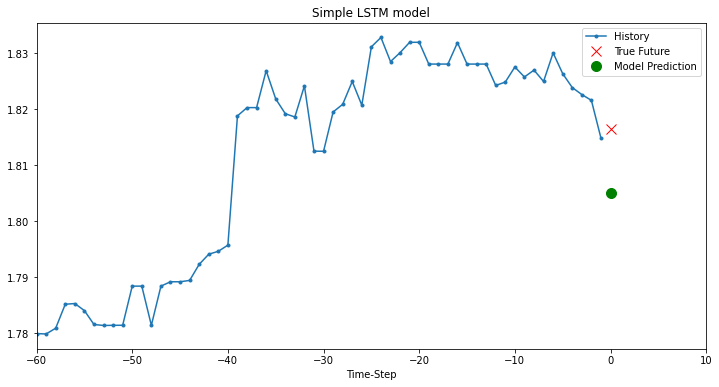

In [32]:
for x, y in val_univariate.take(30):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [0]:

indicators_price_volume = [ta_weighted_price, ta_volume]
price_index = 0 # index of 'MSFT weightedPrice'
indicators_time = ['MSFT monthOfYear',	'MSFT dayOfMonth', 'MSFT dayOfWeek',	'MSFT hourOfDay',	'MSFT minuteOfHour']
indicators_ochl = ['MSFT open',	'MSFT high',	'MSFT low',	'MSFT close'] 
indicators_long_average = ['MSFT Days Avg 3 Low',	'MSFT Days Avg 3 Weighted',	'MSFT Days Avg 3 High',	'MSFT Days Avg 5 Low',	'MSFT Days Avg 5 Weighted',	'MSFT Days Avg 5 High',	'MSFT Days Avg 10 Low',	'MSFT Days Avg 10 Weighted',	'MSFT Days Avg 10 High',	'MSFT Days Avg 20 Low',	'MSFT Days Avg 20 Weighted',	'MSFT Days Avg 20 High',	'MSFT Days Avg 50 Low',	'MSFT Days Avg 50 Weighted',	'MSFT Days Avg 50 High',	'MSFT Days Avg 100 Low',	'MSFT Days Avg 100 Weighted',	'MSFT Days Avg 100 High',	'MSFT Days Avg 200 Low', 'MSFT Days Avg 200 Weighted',	'MSFT Days Avg 200 High']
indicators_short_average = ['MSFT SMA 50',	'MSFT SMA 100',	'MSFT SMA 200',	'MSFT DEMA 5',	'MSFT DEMA 10',	'MSFT DEMA 20']	
indicators_bbands = ['MSFT BBANDS 20 UPPER',	'MSFT BBANDS 20 MIDDLE',	'MSFT BBANDS 20 LOWER',	'MSFT BBANDS 10 UPPER',	'MSFT BBANDS 10 MIDDLE',	'MSFT BBANDS 10 LOWER']	
indicators_momentum_100 = ['MSFT RSI 14',	'MSFT STOCH 14 lowk',	'MSFT STOCH 14 lowd'] 
indicators_momentum_1 = ['MSFT macd',	'MSFT macdsignal',	'MSFT macdhist']
indicators_volume =  [ta_obv]


As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [0]:
# indicators_price_volume = [ta_weighted_price, ta_volume]
# indicators_time = ['MSFT monthOfYear',	'MSFT dayOfMonth', 'MSFT dayOfWeek',	'MSFT hourOfDay',	'MSFT minuteOfHour']
# indicators_ochl = ['MSFT open',	'MSFT high',	'MSFT low',	'MSFT close'] 
# indicators_long_average = ['MSFT Days Avg 3 Low',	'MSFT Days Avg 3 Weighted',	'MSFT Days Avg 3 High',	'MSFT Days Avg 5 Low',	'MSFT Days Avg 5 Weighted',	'MSFT Days Avg 5 High',	'MSFT Days Avg 10 Low',	'MSFT Days Avg 10 Weighted',	'MSFT Days Avg 10 High',	'MSFT Days Avg 20 Low',	'MSFT Days Avg 20 Weighted',	'MSFT Days Avg 20 High',	'MSFT Days Avg 50 Low',	'MSFT Days Avg 50 Weighted',	'MSFT Days Avg 50 High',	'MSFT Days Avg 100 Low',	'MSFT Days Avg 100 Weighted',	'MSFT Days Avg 100 High',	'MSFT Days Avg 200 Low', 'MSFT Days Avg 200 Weighted',	'MSFT Days Avg 200 High']
# indicators_short_average = ['MSFT SMA 50',	'MSFT SMA 100',	'MSFT SMA 200',	'MSFT DEMA 5',	'MSFT DEMA 10',	'MSFT DEMA 20']	
# indicators_bbands = ['MSFT BBANDS 20 UPPER',	'MSFT BBANDS 20 MIDDLE',	'MSFT BBANDS 20 LOWER',	'MSFT BBANDS 10 UPPER',	'MSFT BBANDS 10 MIDDLE',	'MSFT BBANDS 10 LOWER']	
# indicators_momentum_100 = ['MSFT RSI 14',	'MSFT STOCH 14 lowk',	'MSFT STOCH 14 lowd'] 
# indicators_momentum_1 = ['MSFT macd',	'MSFT macdsignal',	'MSFT macdhist']
# indicators_volume =  [ta_obv]

prices_dataset = df[ta_weighted_price].values
volume_dataset = df[ta_volume].values
time_dataset = df[indicators_time].values
ochl_dataset = df[indicators_ochl].values
long_average_dataset = df[indicators_long_average].values
short_average_dataset = df[indicators_short_average].values
bbands_dataset = df[indicators_bbands].values
momentum_100_dataset = df[indicators_momentum_100].values
momentum_1_dataset = df[indicators_momentum_1].values
obv_dataset = df[ta_obv].values


prices_mean = prices_dataset[:TRAIN_SPLIT].mean(axis=0)
prices_std = prices_dataset[:TRAIN_SPLIT].std(axis=0)
prices_dataset = (prices_dataset - prices_mean)/prices_std
ochl_dataset = (ochl_dataset - prices_mean)/prices_std
long_average_dataset = (long_average_dataset - prices_mean)/prices_std
short_average_dataset = (short_average_dataset - prices_mean)/prices_std
bbands_dataset = (bbands_dataset - prices_mean)/prices_std

volume_mean = volume_dataset[:TRAIN_SPLIT].mean(axis=0)
volume_std = volume_dataset[:TRAIN_SPLIT].std(axis=0)
volume_dataset = (volume_dataset - volume_mean)/volume_std

obv_mean = obv_dataset[:TRAIN_SPLIT].mean(axis=0)
obv_std = obv_dataset[:TRAIN_SPLIT].std(axis=0)
obv_dataset = (obv_dataset - obv_mean)/obv_std

momentum_100_dataset = momentum_100_dataset/100


In [0]:
dataset = np.column_stack((prices_dataset, volume_dataset, time_dataset, ochl_dataset, long_average_dataset, short_average_dataset, bbands_dataset, momentum_100_dataset, momentum_1_dataset, obv_dataset))

# remove first 200 NaN rows
dataset = np.delete(dataset, slice(0,199), 0)



### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [0]:
past_history = 60
future_target = 5
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, price_index], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, price_index],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [35]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (60, 51)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [37]:
x_train_single.shape

(116394, 60, 51)

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
optmzer=tf.keras.optimizers.RMSprop()
single_step_model.compile(optimizer=optmzer, loss='mae')

Let's check out a sample prediction.

In [39]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [40]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/20
200/200 [==============================] - 3s 17ms/step - loss: 0.1337 - val_loss: 0.9943
Epoch 2/20
200/200 [==============================] - 3s 15ms/step - loss: 0.0658 - val_loss: 0.4936
Epoch 3/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0695 - val_loss: 0.3173
Epoch 4/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0475 - val_loss: 0.5542
Epoch 5/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0536 - val_loss: 0.2277
Epoch 6/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0405 - val_loss: 0.4088
Epoch 7/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0451 - val_loss: 0.2550
Epoch 8/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0398 - val_loss: 0.3733
Epoch 9/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0371 - val_loss: 0.2652
Epoch 10/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0426 - val_loss

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure(figsize=(12,6))

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

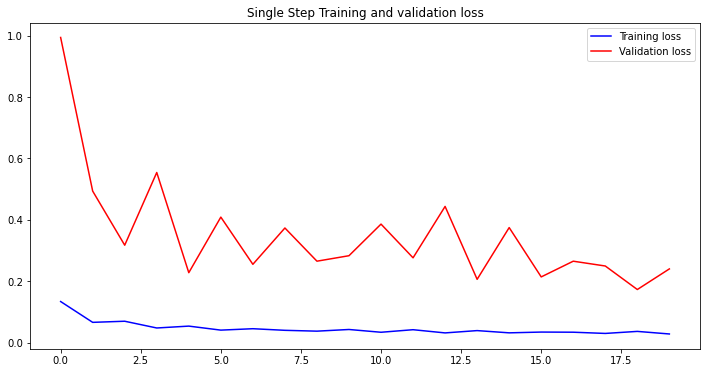

In [42]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

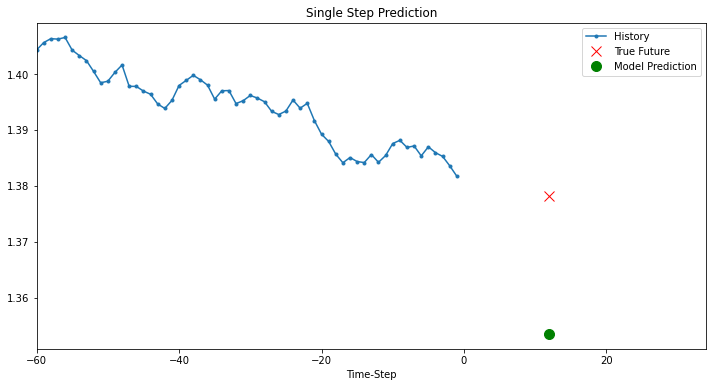

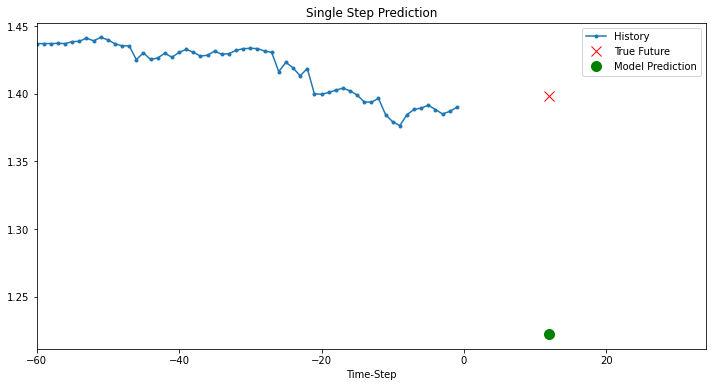

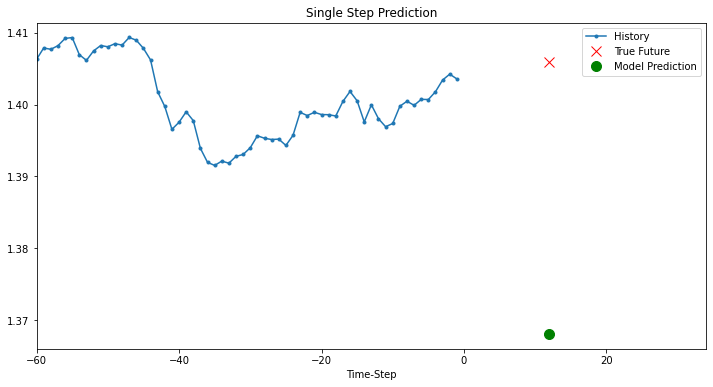

In [43]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, price_index].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [0]:
prediction_size = 1
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, price_index], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 prediction_size, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, price_index],
                                             TRAIN_SPLIT, None, past_history,
                                             prediction_size, STEP)

Let's check out a sample data-point.

In [45]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (60, 51)

 Target temperature to predict : (1,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, price_index]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

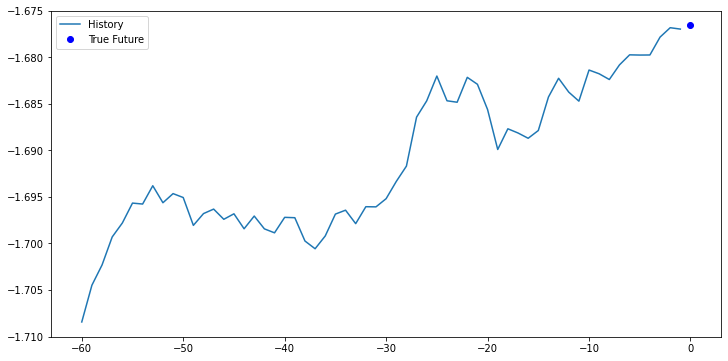

In [48]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [49]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(41, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(23, return_sequences=True, dropout=0.1))
multi_step_model.add(tf.keras.layers.LSTM(13, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(prediction_size))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [50]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 1)


In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[early_stopping],
                                          verbose=1)

Epoch 1/20
200/200 [==============================] - 20s 100ms/step - loss: 0.1622 - val_loss: 1.3912
Epoch 2/20
200/200 [==============================] - 19s 94ms/step - loss: 0.0834 - val_loss: 0.6919
Epoch 3/20
200/200 [==============================] - 18s 91ms/step - loss: 0.0998 - val_loss: 0.4554
Epoch 4/20
200/200 [==============================] - 18s 91ms/step - loss: 0.0558 - val_loss: 0.6195
Epoch 5/20
200/200 [==============================] - 18s 89ms/step - loss: 0.0832 - val_loss: 0.3064
Epoch 6/20
200/200 [==============================] - 18s 89ms/step - loss: 0.0502 - val_loss: 0.6571
Epoch 7/20
200/200 [==============================] - 18s 90ms/step - loss: 0.0623 - val_loss: 0.2916
Epoch 8/20
200/200 [==============================] - 18s 90ms/step - loss: 0.0536 - val_loss: 0.7218
Epoch 9/20
200/200 [==============================] - 18s 88ms/step - loss: 0.0443 - val_loss: 0.3760
Epoch 10/20
200/200 [==============================] - 18s 90ms/step - loss: 0.06

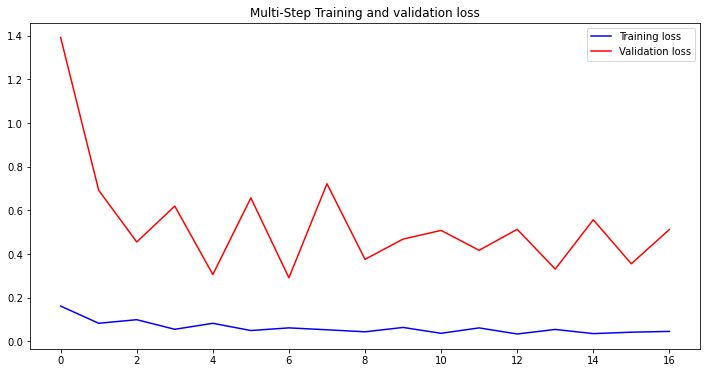

In [52]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

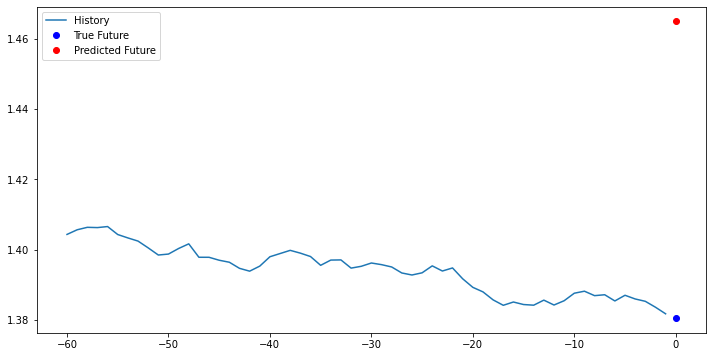

y = tf.Tensor([1.38052541], shape=(1,), dtype=float64) Prediction = [1.4648763] 


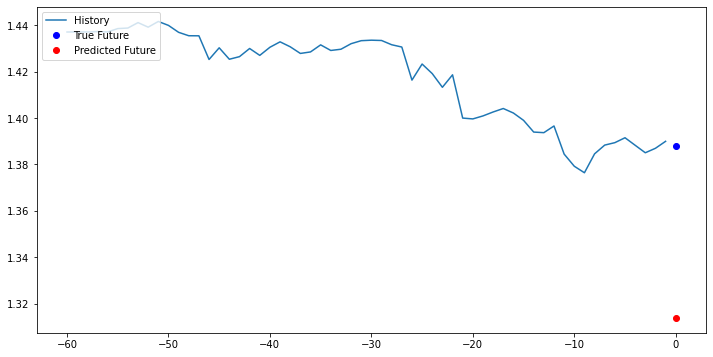

y = tf.Tensor([1.38782392], shape=(1,), dtype=float64) Prediction = [1.3138736] 


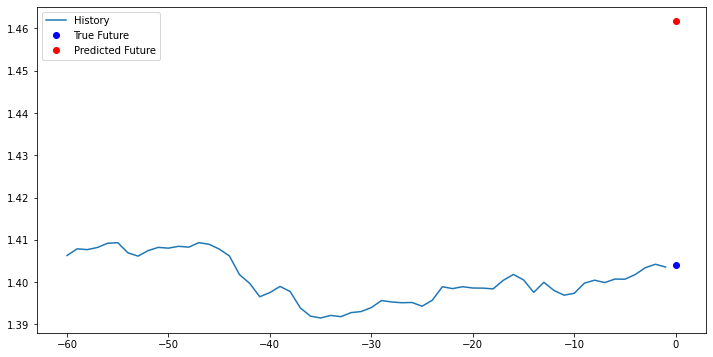

y = tf.Tensor([1.40404541], shape=(1,), dtype=float64) Prediction = [1.4616296] 


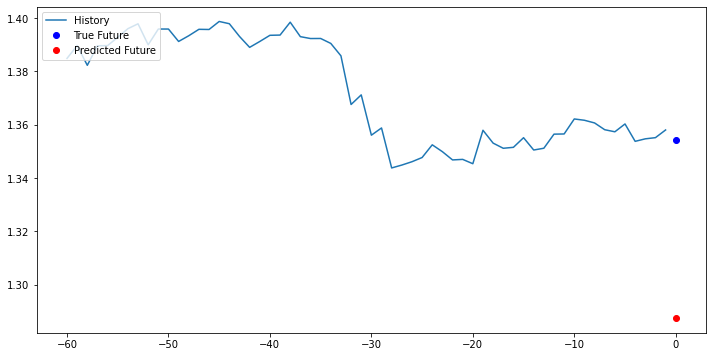

y = tf.Tensor([1.35419949], shape=(1,), dtype=float64) Prediction = [1.2874898] 


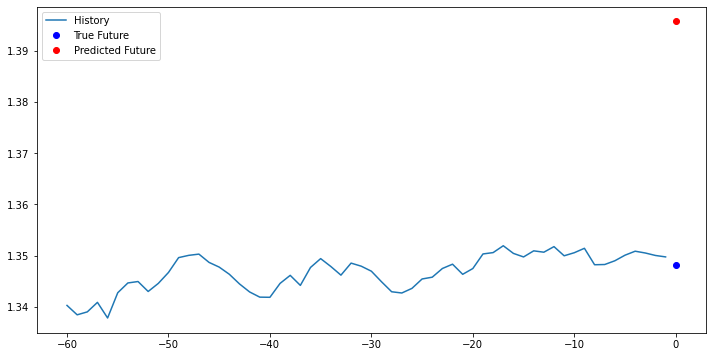

y = tf.Tensor([1.34820679], shape=(1,), dtype=float64) Prediction = [1.3956882] 


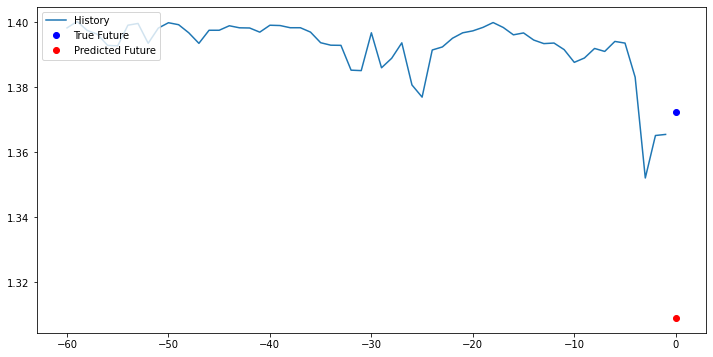

y = tf.Tensor([1.37237969], shape=(1,), dtype=float64) Prediction = [1.3089484] 


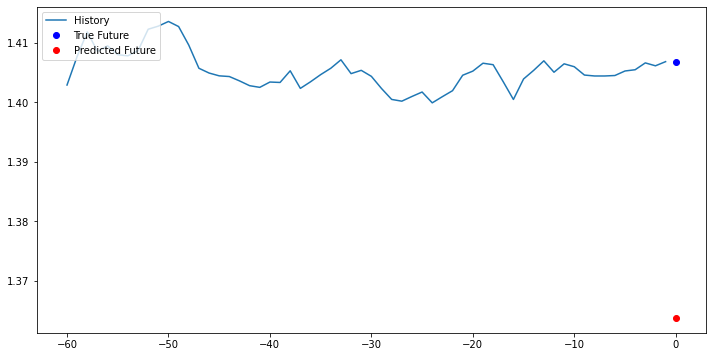

y = tf.Tensor([1.40670365], shape=(1,), dtype=float64) Prediction = [1.3637388] 


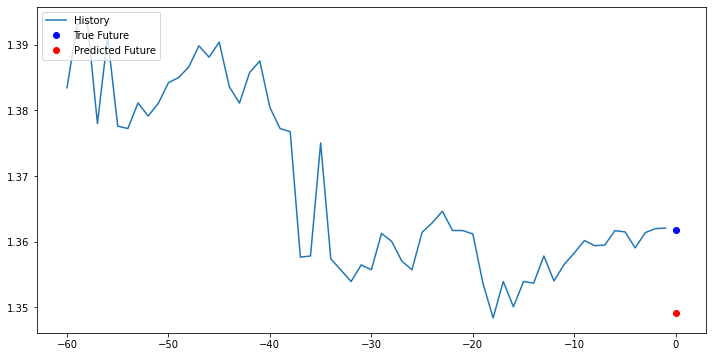

y = tf.Tensor([1.3617234], shape=(1,), dtype=float64) Prediction = [1.3490492] 


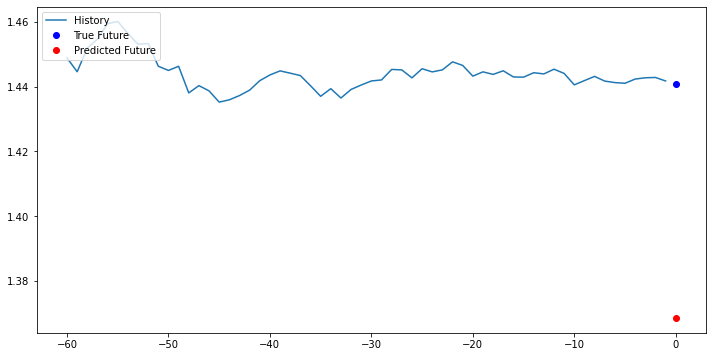

y = tf.Tensor([1.44088771], shape=(1,), dtype=float64) Prediction = [1.3684983] 


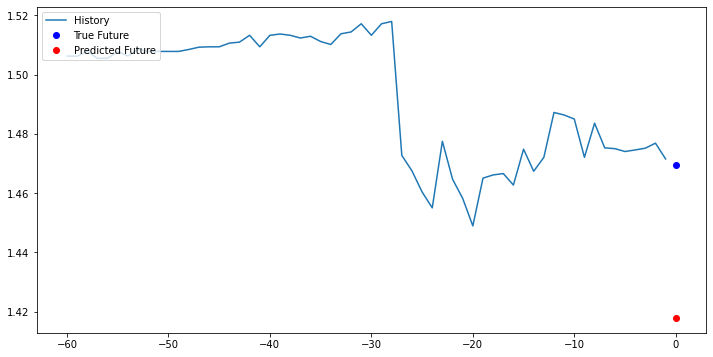

y = tf.Tensor([1.46957651], shape=(1,), dtype=float64) Prediction = [1.4179085] 


In [53]:
for x, y in val_data_multi.take(10):
  prediction = multi_step_model.predict(x)[0]
  multi_step_plot(x[0], y[0], prediction)
  tf.print("y = %s Prediction = %s " % (y[0], prediction))

In [54]:
print(tf.__version__)

2.2.0-dlenv


## Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. You may also check out this [time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing) guide and use it in this tutorial.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).